In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Diet Plan Recommendations

### Loading Dataset

In [2]:
df_train = pd.read_csv('diet_plan_train_dataset.csv')
df_train

,age,gender,bmi,activity_level,calories_to_maintain_weight
0,44,M,35.305202,1.3,2432.9201
1,12,M,14.808755,1.5,1897.8195
2,33,F,27.652338,1.7,2523.4307
3,16,F,20.654095,1.5,2041.6095
4,31,M,28.122479,1.3,2205.0613
...,...,...,...,...,...
10185,12,M,17.214291,1.3,1603.6007
10186,14,M,21.135759,1.2,1805.5224
10187,6,M,12.477581,1.9,1842.4072
10188,20,F,21.441534,1.9,2636.4381


In [3]:
df_test = pd.read_csv('diet_plan_test_dataset.csv')
df_test

,age,gender,bmi,activity_level,calories_to_maintain_weight
0,3.0,F,16.597151,1.9,1876.0524
1,4.0,F,17.227739,1.9,1767.4104
2,3.0,M,14.220153,1.9,1520.3876
3,3.0,F,19.988219,1.3,1212.3111
4,4.0,F,19.994058,1.7,1596.3289
...,...,...,...,...,...
531,50.0,F,36.751454,1.2,1965.5940
532,60.0,F,35.846570,1.5,2352.2685
533,58.0,M,35.886027,1.2,2155.5480
534,84.0,F,36.919486,1.5,2220.2235


### Copying Data to Variable

In [4]:
diet_features_train = df_train.copy()
diet_features_test = df_test.copy()

diet_label_train = diet_features_train.pop('calories_to_maintain_weight')
diet_label_test = diet_features_test.pop('calories_to_maintain_weight')

In [145]:
print(diet_features_train)
print(diet_features_test)

       age gender        bmi  activity_level
0       44      M  35.305202             1.3
1       12      M  14.808755             1.5
2       33      F  27.652338             1.7
3       16      F  20.654095             1.5
4       31      M  28.122479             1.3
...    ...    ...        ...             ...
10185   12      M  17.214291             1.3
10186   14      M  21.135759             1.2
10187    6      M  12.477581             1.9
10188   20      F  21.441534             1.9
10189   28      M  25.593436             1.2

[10190 rows x 4 columns]
      age gender        bmi  activity_level
0     3.0      F  16.597151             1.9
1     4.0      F  17.227739             1.9
2     3.0      M  14.220153             1.9
3     3.0      F  19.988219             1.3
4     4.0      F  19.994058             1.7
..    ...    ...        ...             ...
531  50.0      F  36.751454             1.2
532  60.0      F  35.846570             1.5
533  58.0      M  35.886027           

In [146]:
print(diet_label_train)
print(diet_label_test)

0        2432.9201
1        1897.8195
2        2523.4307
3        2041.6095
4        2205.0613
           ...    
10185    1603.6007
10186    1805.5224
10187    1842.4072
10188    2636.4381
10189    1951.0572
Name: calories_to_maintain_weight, Length: 10190, dtype: float64
0      1876.0524
1      1767.4104
2      1520.3876
3      1212.3111
4      1596.3289
         ...    
531    1965.5940
532    2352.2685
533    2155.5480
534    2220.2235
535    1821.2784
Name: calories_to_maintain_weight, Length: 536, dtype: float64


### Building Preprocessing Model

In [5]:
inputs = {}

for name, column in diet_features_train.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'gender': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'gender')>,
 'bmi': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bmi')>,
 'activity_level': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activity_level')>}

In [6]:
# Preprocessing input berjenis numerik
numeric_inputs = {name:input for name, input in inputs.items()
                  if input.dtype == tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.Normalization()
norm.adapt(np.array(df_train[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization')>

In [7]:
preprocessed_inputs = [all_numeric_inputs]

In [8]:
# Preprocessing input berjenis string
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = tf.keras.layers.StringLookup(
        vocabulary=np.unique(diet_features_train[name])
    )
    one_hot = tf.keras.layers.CategoryEncoding(
        num_tokens=lookup.vocabulary_size()
    )

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

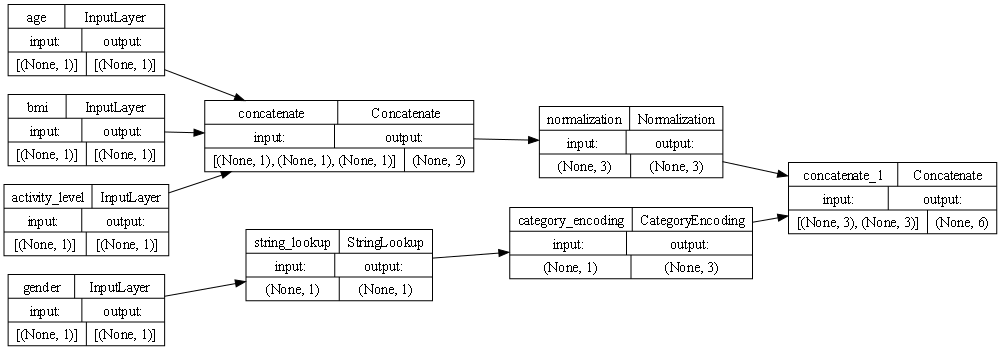

In [9]:
preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)
diet_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
tf.keras.utils.plot_model(
    model=diet_preprocessing,
    rankdir="LR",
    dpi=72,
    show_shapes=True
)

In [152]:
diet_features_train_dict = {name: np.array(value)
                      for name, value in diet_features_train.items()}
diet_features_test_dict = {name: np.array(value)
                           for name, value in diet_features_test.items()}

In [153]:
features_dict = {name: values[:1]
                 for name, values in diet_features_train_dict.items()}
diet_preprocessing(features_dict)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.9465797,  1.5135044, -0.7833693,  0.       ,  0.       ,
         1.       ]], dtype=float32)>

### Build the Model

In [154]:
def create_model(body, preprocessed_head):
    preprocessed_head = diet_preprocessing(inputs)
    result = body(preprocessed_head)
    model = tf.keras.Model(inputs, result)

    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae'])
    
    return model

In [171]:
model_body = tf.keras.Sequential([
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

model = create_model(model_body, preprocessed_inputs)

init_weights = model.get_weights()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 activity_level (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 bmi (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                              

#### Choosing Learning Rate

In [172]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.LogCosh(), optimizer=optimizer, metrics=['mae'])

history = model.fit(diet_features_train_dict, diet_label_train, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
319/319 [==============================] - 4s 6ms/step - loss: 2118.0166 - mae: 2118.3101 - lr: 1.0000e-05
Epoch 2/50
319/319 [==============================] - 2s 5ms/step - loss: 2117.8618 - mae: 2118.1538 - lr: 1.1220e-05
Epoch 3/50
319/319 [==============================] - 2s 5ms/step - loss: 2117.6785 - mae: 2117.9702 - lr: 1.2589e-05
Epoch 4/50
319/319 [==============================] - 2s 5ms/step - loss: 2117.4458 - mae: 2117.7356 - lr: 1.4125e-05
Epoch 5/50
319/319 [==============================] - 1s 5ms/step - loss: 2117.1316 - mae: 2117.4238 - lr: 1.5849e-05
Epoch 6/50
319/319 [==============================] - 2s 5ms/step - loss: 2116.6907 - mae: 2116.9810 - lr: 1.7783e-05
Epoch 7/50
319/319 [==============================] - 2s 6ms/step - loss: 2115.9851 - mae: 2116.2742 - lr: 1.9953e-05
Epoch 8/50
319/319 [==============================] - 2s 5ms/step - loss: 2114.6682 - mae: 2114.9585 - lr: 2.2387e-05
Epoch 9/50
319/319 [==============================] - 1s

C:\Users\Karkar\AppData\Local\Temp\ipykernel_10628\3136561456.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([1e-5, 0, 0, 500])


(1e-05, 0.0037368012538211595, 0.0, 500.0)

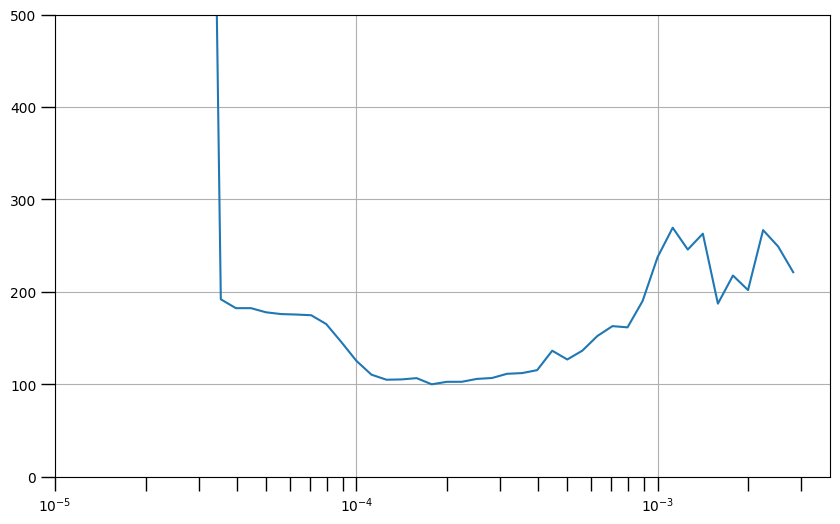

In [173]:
lrs = 1e-5 * (10 ** (np.arange(50) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-5, 0, 0, 500])

#### Traning the Model

In [174]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)

model.compile(loss=tf.keras.losses.LogCosh(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4),
              metrics=['mae'])

history = model.fit(x=diet_features_train_dict,
                    y=diet_label_train,
                    validation_data=(diet_features_test_dict, diet_label_test),
                    epochs=100)

Epoch 1/100
319/319 [==============================] - 5s 9ms/step - loss: 2036.6035 - mae: 2036.8110 - val_loss: 1697.6688 - val_mae: 1697.6365
Epoch 2/100
319/319 [==============================] - 2s 7ms/step - loss: 639.8459 - mae: 639.4690 - val_loss: 155.9551 - val_mae: 155.4333
Epoch 3/100
319/319 [==============================] - 2s 7ms/step - loss: 164.9069 - mae: 164.3827 - val_loss: 130.8550 - val_mae: 130.3192
Epoch 4/100
319/319 [==============================] - 2s 6ms/step - loss: 148.4860 - mae: 147.9314 - val_loss: 105.9735 - val_mae: 105.3907
Epoch 5/100
319/319 [==============================] - 2s 6ms/step - loss: 136.5610 - mae: 135.9648 - val_loss: 97.1883 - val_mae: 96.5733
Epoch 6/100
319/319 [==============================] - 2s 7ms/step - loss: 129.9087 - mae: 129.2829 - val_loss: 89.2470 - val_mae: 88.6064
Epoch 7/100
319/319 [==============================] - 2s 7ms/step - loss: 123.5614 - mae: 122.9092 - val_loss: 85.0045 - val_mae: 84.3371
Epoch 8/100
319

(0.0, 100.0, 0.0, 400.0)

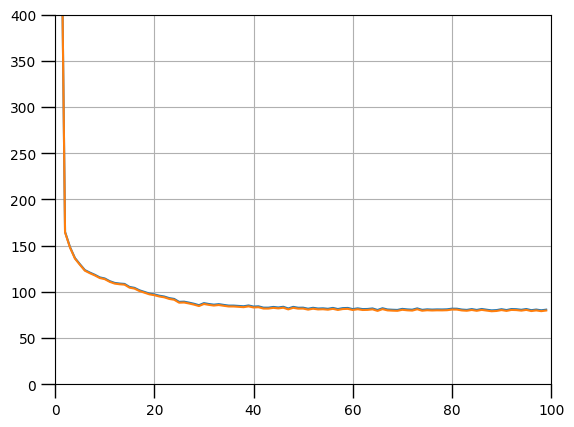

In [175]:
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([0, history.params['epochs'], 0, 400])

In [176]:
results = model.predict(diet_features_test_dict)
result_errors = tf.keras.metrics.mean_absolute_error(diet_label_test, results).numpy()
selisih = (results.reshape((-1)) - diet_label_test).abs()

print('MAE')
print(f'Mean: {result_errors.mean()}')
print(f'Min: {result_errors.min()}')
print(f'Max: {result_errors.max()}')
print(f'Standar Deviasi: {result_errors.std()}')

print('Selisih')
print(f'Mean: {selisih.mean()}')
print(f'Min: {selisih.min()}')
print(f'Max: {selisih.max()}')
print(f'Standar Deviasi: {selisih.std()}')

17/17 [==============================] - 1s 5ms/step
MAE
Mean: 424.6681213378906
Min: 300.67578125
Max: 877.0137939453125
Standar Deviasi: 136.4532012939453
Selisih
Mean: 31.913127343021216
Min: 0.07605468749989086
Max: 338.7983707031251
Standar Deviasi: 42.93182517048058


In [177]:
results

array([[1802.4272],
       [1870.5204],
       [1456.122 ],
       [1243.8677],
       [1695.4977],
       [1380.8718],
       [1628.2397],
       [1754.3833],
       [1535.4486],
       [1966.4033],
       [1302.0309],
       [1629.0514],
       [1366.1305],
       [1429.3292],
       [1795.236 ],
       [1774.3234],
       [1699.5345],
       [1400.3176],
       [1436.4183],
       [1549.8251],
       [1488.7368],
       [1582.7096],
       [1794.3656],
       [1564.2728],
       [1655.7892],
       [1646.2145],
       [1712.6116],
       [1713.095 ],
       [1927.119 ],
       [1307.1652],
       [1827.2252],
       [1925.1946],
       [1527.2018],
       [1898.4396],
       [1431.6649],
       [1420.6066],
       [1814.3993],
       [1815.3036],
       [1363.091 ],
       [1651.5695],
       [1614.6273],
       [1592.0907],
       [1559.9789],
       [1634.6039],
       [1626.6334],
       [1794.2925],
       [1598.0021],
       [1388.6698],
       [1657.5062],
       [1861.669 ],


In [178]:
result_errors

array([392.60767, 360.2057 , 669.5239 , 877.0138 , 465.6326 , 742.67914,
       515.4831 , 423.67084, 594.96173, 322.88748, 819.9357 , 514.83795,
       757.066  , 695.48755, 396.80276, 410.062  , 462.7266 , 723.7414 ,
       688.60223, 581.85016, 638.5743 , 552.9279 , 397.3221 , 569.042  ,
       494.4909 , 501.58145, 453.35797, 453.01166, 337.73547, 814.8973 ,
       379.24258, 338.48227, 602.597  , 349.0109 , 693.2138 , 703.9824 ,
       385.92233, 385.4432 , 760.03754, 497.60843, 526.39606, 544.9585 ,
       572.82056, 510.44897, 516.75977, 397.36578, 540.02466, 735.08496,
       493.22226, 363.88864, 616.1553 , 652.8133 , 398.4448 , 532.9531 ,
       560.03674, 410.37915, 378.65182, 556.266  , 374.0355 , 386.82312,
       505.96304, 638.5476 , 482.0822 , 544.39856, 363.35004, 301.007  ,
       542.4429 , 495.13876, 399.48538, 321.81952, 583.61285, 320.43988,
       332.26205, 573.44666, 324.9691 , 371.64755, 578.7851 , 365.9938 ,
       530.8691 , 369.2469 , 392.6391 , 354.60263, 

### Save Model

#### Convert to TFLite

In [179]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmp1pkfcvm3\assets


INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmp1pkfcvm3\assets


In [180]:
import pathlib

tflite_models_dir = pathlib.Path("diet_plan_model/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"diet_plan_model.tflite"
tflite_model_file.write_bytes(tflite_model)

211136

In [181]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = tflite_models_dir/"diet_plan_model_3.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmpbpc231z6\assets


INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmpbpc231z6\assets


59224

### Interpret TFLite Model

In [182]:
interpreter = tf.lite.Interpreter(model_path='diet_plan_model\\diet_plan_model_3.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()
output_index = interpreter.get_output_details()[0]['index']

In [183]:
for item in input_index:
    print(item)
print(interpreter.get_output_details())

{'name': 'serving_default_activity_level:0', 'index': 0, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_default_age:0', 'index': 1, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_default_bmi:0', 'index': 2, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_de

In [184]:
test_dict = {name: np.expand_dims(values[:1], axis=0)
                 for name, values in diet_features_test_dict.items()}
#preprocessed_test = diet_preprocessing(test_dict)
#print(preprocessed_test)
print(test_dict)

{'age': array([[3.]]), 'gender': array([['F']], dtype=object), 'bmi': array([[16.59715123]]), 'activity_level': array([[1.9]])}


In [185]:
# Dictionary itu struktur data yang tidak terurut, jadi nilai input
# dimasukkan secara manual
interpreter.set_tensor(input_index[0]['index'], test_dict['activity_level'].astype(np.float32))
interpreter.set_tensor(input_index[1]['index'], test_dict['age'].astype(np.float32))
interpreter.set_tensor(input_index[2]['index'], test_dict['bmi'].astype(np.float32))
interpreter.set_tensor(input_index[3]['index'], test_dict['gender'])
interpreter.invoke()
output = interpreter.get_tensor(output_index)

In [186]:
print(output)
print(diet_label_train.iloc[0])

[[1793.7128]]
2432.9201000000003
